In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
import copy
import math

In [2]:
reps = pd.read_pickle('customer_service_reps')
reps = reps.reset_index(drop=True)
reps = reps.drop_duplicates(subset=['subid'], keep='first')
reps = reps.reset_index(drop=True)
reps

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
0,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,0,2019-11-26 03:30:29,2019-11-26 03:30:29,NaN
1,31174901,25914865,True,NaT,2020-03-19 01:20:25,14,True,itunes,1.1377,0,2020-03-19 01:20:25,2020-04-02 01:20:25,NaN
2,32408758,28778936,True,NaT,2020-03-27 23:46:37,0,True,google,1.1377,0,2020-03-27 23:46:37,2020-03-28 06:47:31,NaN
3,39370969,21481314,True,NaT,2020-03-27 23:09:18,0,True,google,1.1377,0,2020-03-27 23:09:18,2020-03-28 05:09:22,NaN
4,38637729,24230000,True,NaT,2020-03-27 22:59:09,0,True,google,1.1377,0,2020-03-27 22:59:09,2020-03-28 04:59:17,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369355,31803812,21965147,False,2019-07-04 15:37:24,2019-06-30 00:00:13,14,False,OTT,0.0000,0,2019-06-30 00:00:13,NaT,NaN
1369356,33218156,21781165,True,NaT,2019-06-30 00:00:06,14,True,OTT,3.8902,0,2019-06-30 00:00:06,2019-07-14 11:05:50,NaN
1369357,34478389,27625059,False,2019-07-01 10:27:01,2019-06-30 00:00:06,14,False,OTT,0.0000,0,2019-06-30 00:00:06,NaT,NaN
1369358,38647874,27845350,False,NaT,2019-06-30 00:00:04,14,True,OTT,3.5232,0,2019-06-30 00:00:04,2019-07-14 11:07:06,NaN


In [3]:
engagement = pd.read_pickle('engagement')
engagement = engagement.groupby(['subid']).agg({'app_opens':'mean','cust_service_mssgs':'mean','num_videos_completed':'mean','num_videos_more_than_30_seconds':'mean','num_videos_rated':'mean','num_series_started':'mean','payment_period':'mean'}).reset_index()
engagement

,subid,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
0,20000062,1.000000,0.750000,1.500000,5.750000,0.000000,0.250000,0.000000
1,20000405,1.250000,1.000000,3.250000,4.250000,0.000000,0.250000,0.000000
2,20000604,0.933333,0.333333,0.533333,4.533333,0.000000,0.066667,0.133333
3,20000685,1.210526,0.263158,0.368421,4.342105,0.000000,0.210526,0.657895
4,20000741,0.500000,0.500000,1.000000,3.500000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
135014,29999740,1.071429,0.214286,0.785714,2.214286,0.000000,0.000000,0.000000
135015,29999820,1.200000,0.600000,2.200000,5.000000,0.000000,0.700000,0.000000
135016,29999822,1.000000,0.800000,0.400000,5.000000,0.000000,0.200000,0.000000
135017,29999889,3.223684,0.592105,4.289474,4.289474,0.526316,0.894737,1.197368


In [4]:
spend = pd.read_excel('advertising_spend_data.xlsx',header=2)
spend

,date,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
0,2019-06-30,84800,75000,17300,21400,11900,10500,5900,6100
1,2019-07-31,60000,75600,17300,21300,12000,29800,6000,6600
2,2019-08-31,52300,76100,18100,21300,16300,65900,6200,6800
3,2019-09-30,49000,75800,18900,21300,16400,73700,6000,7400
4,2019-10-31,51300,76000,21000,21400,12200,32300,6700,7300
5,2019-11-30,56100,75900,21400,21600,11700,9800,6300,7300
6,2019-12-31,51400,76100,32100,22200,12100,3500,7200,8000
7,2020-01-31,49000,75500,33600,22700,14300,300,6700,7400
8,2020-02-29,49700,76600,30100,21700,15000,300,6400,6500
9,2020-03-31,49100,78000,22700,21200,17600,300,5900,10000


In [5]:
subscribers = pd.read_csv('subscribers.csv')
subscribers

,Unnamed: 0,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,...,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed
0,162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,...,NaN,ar,Standard Charter,14,True,1,2020-02-07 21:44:16,2020-06-07 21:44:16,NaN,True
1,380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,...,0.3303,ar,NaN,14,True,1,2020-03-15 15:44:35,2020-07-15 15:44:35,NaN,True
2,496617,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,...,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True
3,356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,...,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True
4,681701,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,...,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227623,509326,21434712,enhanced,3.0,comedy,supplement OTT,28.751405,2.0,38.0,False,...,0.3303,ar,NaN,14,True,1,2019-12-01 14:12:33,2020-04-01 14:12:33,NaN,True
227624,229587,25843074,enhanced,2.0,comedy,replace OTT,27.301448,2.0,49.0,False,...,0.3303,ar,Paypal,14,True,1,2019-12-20 18:02:13,2020-04-20 18:02:13,NaN,True
227625,281340,24799085,base,NaN,comedy,access to exclusive content,31.651317,NaN,45.0,False,...,0.0367,ar,NaN,14,True,1,2020-01-04 19:40:44,2020-05-04 19:40:44,NaN,True
227626,87198,21308040,base,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,...,NaN,ar,Paypal,14,True,1,2020-01-31 23:58:51,2020-05-31 23:58:51,NaN,True


In [6]:
for i in range(len(subscribers)):
    
    if subscribers['weekly_consumption_hour'][i] < 0: 
        subscribers['weekly_consumption_hour'][i] = 0 
    
    if subscribers['num_ideal_streaming_services'][i] < 0: 
        subscribers['num_ideal_streaming_services'][i] = 0 

    if subscribers['age'][i] < 0:
        subscribers['age'][i] = 0
        
    if subscribers['age'][i] > 100:
        subscribers['age'][i] = 100 
        
    if subscribers['join_fee'][i] < 0:
        subscribers['join_fee'][i] = 0 

<ipython-input-6-fd8e613aca8e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subscribers['age'][i] = 100
<ipython-input-6-fd8e613aca8e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subscribers['weekly_consumption_hour'][i] = 0
<ipython-input-6-fd8e613aca8e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subscribers['join_fee'][i] = 0
<ipython-input-6-fd8e613aca8e>:7: SettingWithCopyWarning: 
A value is trying to be set on a 

In [7]:
subscribers['trial_completed_binary'] = np.where(subscribers['trial_completed']==True, 1, 0)

In [8]:
subscribers_total = pd.merge(subscribers, reps[['subid','revenue_net_1month','renew']], how='inner', on = 'subid')
subscribers_total = pd.merge(subscribers_total, engagement, how='inner', on = 'subid')
subscribers_total

,Unnamed: 0,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,...,trial_completed_binary,revenue_net_1month,renew,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period_y
0,496617,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,...,1,0.0000,False,1.000000,1.000000,6.500000,6.500000,0.000000,0.500000,0.000000
1,192823,29726122,base,2.0,comedy,access to exclusive content,20.051667,2.0,61.0,False,...,1,4.5875,True,0.975610,0.414634,4.439024,4.439024,0.146341,0.951220,0.756098
2,315863,20299962,base,3.0,drama,access to exclusive content,34.551230,2.0,23.0,False,...,1,3.4498,True,2.260870,0.217391,1.826087,4.478261,0.000000,0.630435,0.673913
3,254782,24930568,base,NaN,comedy,access to exclusive content,25.851492,NaN,73.0,False,...,1,0.0000,False,1.500000,1.500000,1.000000,6.500000,0.000000,0.000000,0.000000
4,290426,21361112,enhanced,NaN,comedy,access to exclusive content,37.451142,NaN,24.0,True,...,1,0.0000,False,2.000000,1.500000,1.000000,6.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135014,230734,21928274,base,NaN,drama,replace OTT,NaN,NaN,NaN,False,...,1,4.5875,True,1.785714,0.571429,3.285714,6.285714,0.107143,0.785714,0.464286
135015,577745,25549852,enhanced,NaN,comedy,access to exclusive content,28.751405,NaN,61.0,False,...,1,0.0000,False,1.000000,2.000000,0.000000,6.000000,0.000000,0.000000,0.000000
135016,603751,25835684,base,2.0,drama,access to exclusive content,24.401536,2.0,43.0,False,...,1,0.0000,False,2.583333,0.416667,3.916667,4.916667,0.000000,0.666667,0.000000
135017,509326,21434712,enhanced,3.0,comedy,supplement OTT,28.751405,2.0,38.0,False,...,1,0.0000,False,1.777778,0.333333,2.222222,4.000000,0.000000,0.222222,0.000000


### Customer Segmentation

In [9]:
cluster_columns=['subid','num_weekly_services_utilized','num_videos_completed','num_videos_more_than_30_seconds','num_videos_rated','num_series_started']
cluster_data = subscribers_total.dropna(subset=cluster_columns)
cluster_data

,Unnamed: 0,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,...,trial_completed_binary,revenue_net_1month,renew,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period_y
0,496617,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,...,1,0.0000,False,1.000000,1.000000,6.500000,6.500000,0.000000,0.500000,0.000000
1,192823,29726122,base,2.0,comedy,access to exclusive content,20.051667,2.0,61.0,False,...,1,4.5875,True,0.975610,0.414634,4.439024,4.439024,0.146341,0.951220,0.756098
2,315863,20299962,base,3.0,drama,access to exclusive content,34.551230,2.0,23.0,False,...,1,3.4498,True,2.260870,0.217391,1.826087,4.478261,0.000000,0.630435,0.673913
5,277565,25393847,base,2.0,regional,supplement OTT,28.751405,2.0,57.0,False,...,1,0.0000,False,2.400000,0.800000,3.600000,4.400000,0.000000,0.600000,0.000000
6,377093,23163827,economy,3.0,comedy,replace OTT,33.101274,2.0,54.0,False,...,1,0.0000,False,5.071429,0.428571,3.714286,4.857143,0.000000,0.857143,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135010,243775,26828621,base,4.0,drama,access to exclusive content,27.301448,2.0,44.0,False,...,1,-0.6973,True,1.000000,0.500000,1.500000,5.500000,0.000000,0.500000,0.000000
135013,378377,25492551,base,3.0,comedy,access to exclusive content,30.201361,2.0,32.0,False,...,1,0.0000,False,1.500000,2.000000,6.000000,6.500000,0.000000,0.500000,0.000000
135016,603751,25835684,base,2.0,drama,access to exclusive content,24.401536,2.0,43.0,False,...,1,0.0000,False,2.583333,0.416667,3.916667,4.916667,0.000000,0.666667,0.000000
135017,509326,21434712,enhanced,3.0,comedy,supplement OTT,28.751405,2.0,38.0,False,...,1,0.0000,False,1.777778,0.333333,2.222222,4.000000,0.000000,0.222222,0.000000


In [10]:
cluster_df = cluster_data[cluster_columns]
cluster_df.set_index('subid',inplace=True)
cluster_df

,num_weekly_services_utilized,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started
subid,,,,,
26844789,3.0,6.500000,6.500000,0.000000,0.500000
29726122,2.0,4.439024,4.439024,0.146341,0.951220
20299962,3.0,1.826087,4.478261,0.000000,0.630435
25393847,2.0,3.600000,4.400000,0.000000,0.600000
23163827,3.0,3.714286,4.857143,0.000000,0.857143
...,...,...,...,...,...
26828621,4.0,1.500000,5.500000,0.000000,0.500000
25492551,3.0,6.000000,6.500000,0.000000,0.500000
25835684,2.0,3.916667,4.916667,0.000000,0.666667


In [11]:
train,test = train_test_split(cluster_df,random_state=73,test_size=0.2)

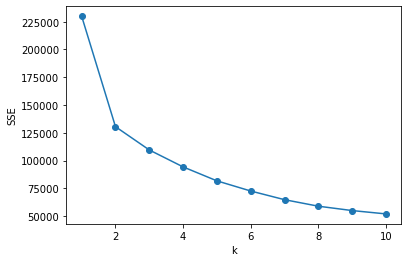

In [12]:
SSE = []
for k in range(1, 11):
    estimator = KMeans(n_clusters=k)
    estimator.fit(train)
    SSE.append(estimator.inertia_)
X = range(1, 11)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X, SSE, 'o-')
plt.show()

set k = 2

In [13]:
model = KMeans(n_clusters=2)
model.fit(train)

KMeans(n_clusters=2)

In [14]:
cluster_centers = model.cluster_centers_

In [15]:
train_labels = model.labels_
test_labels = model.predict(test)

In [16]:
attribute = cluster_data.drop_duplicates(keep='first', subset=['subid'])
attribute.set_index('subid',inplace=True)

train_index = train.index
train_labels = pd.DataFrame(train_labels,index=train_index)
test_index = test.index
test_labels = pd.DataFrame(test_labels,index=test_index)

train_labels['train/test'] = 'Train'
test_labels['train/test'] = 'Test'

labels = pd.concat([train_labels,test_labels])
labels.rename(columns={0:'label'},inplace=True)

output = pd.merge(attribute,labels,right_index=True,left_index=True,how='inner')
output = output.reset_index(drop=False)

In [17]:
output

,subid,Unnamed: 0,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,...,renew,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period_y,label,train/test
0,26844789,496617,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,...,False,1.000000,1.000000,6.500000,6.500000,0.000000,0.500000,0.000000,0,Train
1,29726122,192823,base,2.0,comedy,access to exclusive content,20.051667,2.0,61.0,False,...,True,0.975610,0.414634,4.439024,4.439024,0.146341,0.951220,0.756098,0,Train
2,20299962,315863,base,3.0,drama,access to exclusive content,34.551230,2.0,23.0,False,...,True,2.260870,0.217391,1.826087,4.478261,0.000000,0.630435,0.673913,1,Test
3,25393847,277565,base,2.0,regional,supplement OTT,28.751405,2.0,57.0,False,...,False,2.400000,0.800000,3.600000,4.400000,0.000000,0.600000,0.000000,0,Train
4,23163827,377093,economy,3.0,comedy,replace OTT,33.101274,2.0,54.0,False,...,False,5.071429,0.428571,3.714286,4.857143,0.000000,0.857143,0.000000,0,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80790,26828621,243775,base,4.0,drama,access to exclusive content,27.301448,2.0,44.0,False,...,True,1.000000,0.500000,1.500000,5.500000,0.000000,0.500000,0.000000,1,Train
80791,25492551,378377,base,3.0,comedy,access to exclusive content,30.201361,2.0,32.0,False,...,False,1.500000,2.000000,6.000000,6.500000,0.000000,0.500000,0.000000,0,Test
80792,25835684,603751,base,2.0,drama,access to exclusive content,24.401536,2.0,43.0,False,...,False,2.583333,0.416667,3.916667,4.916667,0.000000,0.666667,0.000000,0,Train
80793,21434712,509326,enhanced,3.0,comedy,supplement OTT,28.751405,2.0,38.0,False,...,False,1.777778,0.333333,2.222222,4.000000,0.000000,0.222222,0.000000,1,Train


In [18]:
output.to_csv('output.csv')

In [19]:
cluster1 = output[output['label']==0]
cluster2 = output[output['label']==1]

In [20]:
cluster1.to_csv('output1.csv')
cluster2.to_csv('output2.csv')

In [21]:
print(len(cluster1),len(cluster2))

43013 37782


### Churn

In [22]:
pd.options.display.max_columns = 25

In [23]:
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['renew'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['renew'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['renew'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['prob_churn_lpm'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact

In [24]:
def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives

In [25]:
subscribers_total_churn = subscribers_total[subscribers_total['renew'].notna()]

In [26]:
y_col_name = 'renew'  
x_col_name = ['subid','age','male_TF','monthly_price','discount_price','num_weekly_services_utilized','weekly_consumption_hour','package_type','preferred_genre','intended_use','app_opens','cust_service_mssgs','num_videos_completed','num_videos_more_than_30_seconds','num_videos_rated','num_series_started','payment_period_y']
col_name = ['renew','subid','age','male_TF','monthly_price','discount_price','num_weekly_services_utilized','weekly_consumption_hour','package_type','preferred_genre','intended_use','app_opens','cust_service_mssgs','num_videos_completed','num_videos_more_than_30_seconds','num_videos_rated','num_series_started','payment_period_y']
add_constant_TF = True

In [27]:
subscribers_total_churn = subscribers_total_churn[col_name]
subscribers_total_churn = subscribers_total_churn.dropna(how='any')

In [28]:
subscribers_total_churn = subscribers_total_churn.reset_index(drop=True)

In [29]:
subscribers_dummy = pd.concat((subscribers_total_churn,pd.get_dummies(subscribers_total_churn['package_type'])), axis=1)
subscribers_dummy = pd.concat((subscribers_dummy,pd.get_dummies(subscribers_total_churn['preferred_genre'])), axis=1)
subscribers_dummy = pd.concat((subscribers_dummy,pd.get_dummies(subscribers_total_churn['intended_use'])), axis=1)
subscribers_dummy

,renew,subid,age,male_TF,monthly_price,discount_price,num_weekly_services_utilized,weekly_consumption_hour,package_type,preferred_genre,intended_use,app_opens,...,comedy,drama,international,other,regional,access to exclusive content,education,expand international access,expand regional access,other,replace OTT,supplement OTT
0,False,26844789,25.0,True,4.7343,4.5141,3.0,36.001186,enhanced,regional,replace OTT,1.000000,...,0,0,0,0,1,0,0,0,0,0,1,0
1,True,29726122,61.0,False,4.7343,4.5141,2.0,20.051667,base,comedy,access to exclusive content,0.975610,...,1,0,0,0,0,1,0,0,0,0,0,0
2,True,20299962,23.0,False,4.7343,4.5141,3.0,34.551230,base,drama,access to exclusive content,2.260870,...,0,1,0,0,0,1,0,0,0,0,0,0
3,False,25393847,57.0,False,4.7343,4.5141,2.0,28.751405,base,regional,supplement OTT,2.400000,...,0,0,0,0,1,0,0,0,0,0,0,1
4,False,23163827,54.0,False,4.7343,4.5141,3.0,33.101274,economy,comedy,replace OTT,5.071429,...,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61087,True,26828621,44.0,False,4.7343,4.5141,4.0,27.301448,base,drama,access to exclusive content,1.000000,...,0,1,0,0,0,1,0,0,0,0,0,0
61088,False,25492551,32.0,False,4.7343,4.5141,3.0,30.201361,base,comedy,access to exclusive content,1.500000,...,1,0,0,0,0,1,0,0,0,0,0,0
61089,False,25835684,43.0,False,4.7343,4.5141,2.0,24.401536,base,drama,access to exclusive content,2.583333,...,0,1,0,0,0,1,0,0,0,0,0,0
61090,False,21434712,38.0,False,4.7343,4.5141,3.0,28.751405,enhanced,comedy,supplement OTT,1.777778,...,1,0,0,0,0,0,0,0,0,0,0,1


In [30]:
conditions = [(subscribers_dummy['male_TF'] == True),(subscribers_dummy['male_TF'] == False),(subscribers_dummy['male_TF'].isna())]
choices = [1, 0, 999]
subscribers_dummy['male_TF_binary'] = np.select(conditions, choices)

In [31]:
subscribers_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61092 entries, 0 to 61091
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   renew                            61092 non-null  object 
 1   subid                            61092 non-null  int64  
 2   age                              61092 non-null  float64
 3   male_TF                          61092 non-null  object 
 4   monthly_price                    61092 non-null  float64
 5   discount_price                   61092 non-null  float64
 6   num_weekly_services_utilized     61092 non-null  float64
 7   weekly_consumption_hour          61092 non-null  float64
 8   package_type                     61092 non-null  object 
 9   preferred_genre                  61092 non-null  object 
 10  intended_use                     61092 non-null  object 
 11  app_opens                        61092 non-null  float64
 12  cust_service_mssgs

In [32]:
subscribers_dummy.columns.values[24] = 'other genre'
subscribers_dummy.columns.values[30] = 'other use'

In [33]:
subscribers_dummy = subscribers_dummy.reset_index(drop=True)

In [34]:
y_col_name = 'renew'  
x_col_name = ['age','male_TF_binary','monthly_price','discount_price','num_weekly_services_utilized','weekly_consumption_hour','base','economy','enhanced','comedy','drama','international','other genre','regional','access to exclusive content','education','expand international access','expand regional access','other use','replace OTT','supplement OTT','app_opens','cust_service_mssgs','num_videos_completed','num_videos_more_than_30_seconds','num_videos_rated','num_series_started','payment_period_y']
add_constant_TF = True

In [35]:
subscribers_churn = pd.DataFrame(subscribers_dummy[y_col_name])
subscribers_churn = pd.merge(subscribers_churn,subscribers_dummy[x_col_name],right_index=True,left_index=True,how='inner')

In [36]:
df_train, df_test = model_selection.train_test_split(subscribers_churn, test_size=0.2)

In [37]:
if add_constant_TF:
    x_col_name.append('const')
    df_train = sm.add_constant(df_train, has_constant='add')
    df_test = sm.add_constant(df_test, has_constant='add')

In [38]:
lpm_model = sm.OLS(endog=df_train[y_col_name].astype(float), exog=df_train[x_col_name].astype(float))
lpm_results = lpm_model.fit()
print("\nRESULTS OF LINEAR MODEL FITTING\n")
print(lpm_results.summary())


RESULTS OF LINEAR MODEL FITTING

                            OLS Regression Results                            
Dep. Variable:                  renew   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     6229.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        16:48:53   Log-Likelihood:                 2537.5
No. Observations:               48873   AIC:                            -5023.
Df Residuals:                   48847   BIC:                            -4794.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [39]:
logit_model = sm.Logit(endog=df_train[y_col_name].astype(float), exog=df_train[x_col_name].astype(float))
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())

         Current function value: 0.056247
         Iterations: 35

RESULTS OF LOGIT MODEL FITTING

                           Logit Regression Results                           
Dep. Variable:                  renew   No. Observations:                48873
Model:                          Logit   Df Residuals:                    48847
Method:                           MLE   Df Model:                           25
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.9113
Time:                        16:48:54   Log-Likelihood:                -2749.0
converged:                      False   LL-Null:                       -30987.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
age                                 0.0050      0.003      1.565     

/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
# ----- EVALUATE MODEL PERFORMANCE -----
# --- evaluate model predictions on test set graphically
df_test['prob_churn_lpm'] = lpm_results.predict(df_test[x_col_name].astype(float))
df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name].astype(float))

In [41]:
len([x for x in x_col_name if x != 'const'])

28

In [42]:
df_test['renew']

8797     False
9840      True
55186     True
51750     True
41538     True
         ...  
59881    False
6860     False
30960     True
59209     True
33062    False
Name: renew, Length: 12219, dtype: object

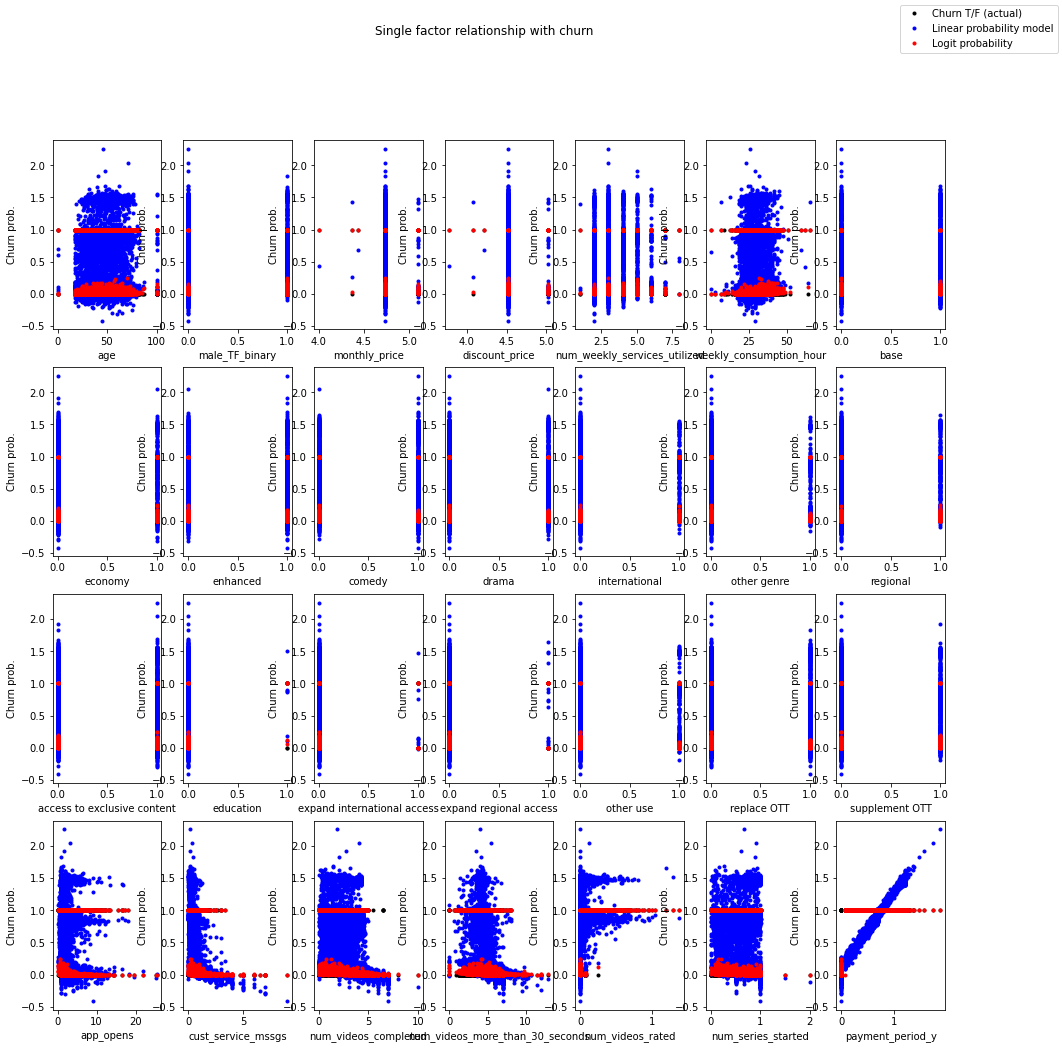

In [43]:
# plot predictions vs. data
select_plot_coef = [x for x in x_col_name if x != 'const']
n_rows = 4
n_cols = math.ceil(len(select_plot_coef) / n_rows)
fig, axes = plt.subplots(n_rows, n_cols)
fig.suptitle('Single factor relationship with churn')
for i in range(n_rows):
    for j in range(n_cols):
        select_coef = select_plot_coef[i * n_cols + j]
        axes[i, j].plot(df_test[select_coef], df_test['renew'], 'k.')
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_lpm'], 'b.')
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_logit'], 'r.')
        axes[i, j].set(xlabel=select_coef, ylabel='Churn prob.')
fig.set_size_inches(16, 16)
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

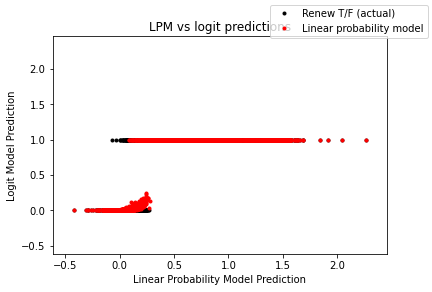

In [45]:
# compare lpm and logit predictions
fig = plt.figure()
ax = plt.gca()
ax.plot(df_test[['prob_churn_lpm']], df_test[['renew']], 'k.')
ax.plot(df_test[['prob_churn_lpm']], df_test[['prob_churn_logit']], 'r.')
plt.ylim(df_test[['prob_churn_lpm', 'prob_churn_logit']].min().min()-.2, df_test[['prob_churn_lpm', 'prob_churn_logit']].max().max()+.2)
plt.xlim(ax.get_ylim())
plt.title('LPM vs logit predictions')
plt.xlabel('Linear Probability Model Prediction')
plt.ylabel('Logit Model Prediction')
fig.legend(labels=['Renew T/F (actual)', 'Linear probability model', 'Logit probability'])

In [49]:
# --- evaluate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test['renew'].astype(float), df_test['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df_test['renew'].astype(float), df_test['prob_churn_lpm'])

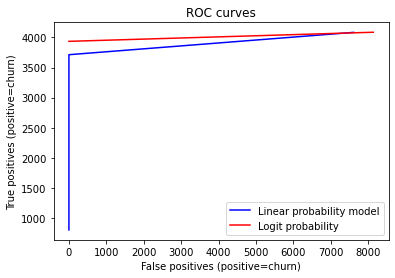

In [50]:
# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, 'b-')
ax1.plot(logit_false_positives, logit_true_positives, 'r-')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

In [53]:
# check current price & discount
print(subscribers_churn['monthly_price'].value_counts())
print(subscribers_churn['discount_price'].value_counts())
print(subscribers_churn['discount_price'].value_counts().index.to_list()[0]/subscribers_churn['monthly_price'].value_counts().index.to_list()[0])

4.7343    60908
5.1013      174
4.4407        5
4.3673        3
4.0003        2
Name: monthly_price, dtype: int64
4.5141    60907
5.0279      174
4.2205        5
4.0737        3
3.7801        2
4.3673        1
Name: discount_price, dtype: int64
0.9534883720930232


In [54]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 4.73
discount_amount = 0.05
cases = ['no_offer', 'lpm_offer', 'logit_offer']

In [55]:
# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

In [56]:
# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    acc_rate_churn = 0.3 + 2 * t_discount_amount
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acc_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

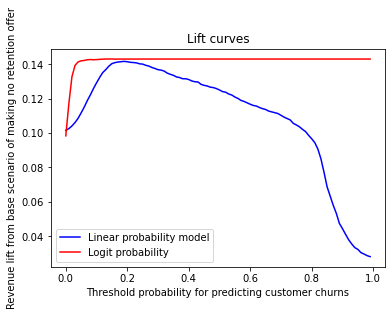

In [57]:
# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

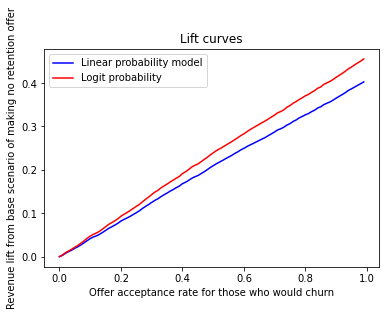

In [59]:
# Acceptance rate sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['lpm_offer'], 'b-')
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

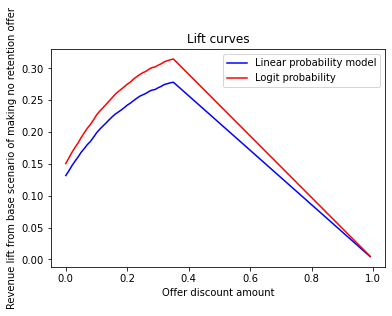

In [61]:
# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

In [62]:
fig.savefig('lift_curve_discount.png', transparent=True)

### Attribution & Allocation

In [63]:
subscribers_channel = subscribers_total[subscribers_total['attribution_technical'].isin(spend.columns)]

In [64]:
subscribers_channel['revenue_net_1month'].value_counts()

0.0000    64582
4.5875    24058
4.8811     2097
3.4498     1859
3.6700     1509
          ...  
3.1195        1
0.2202        1
3.0828        1
4.2205        1
3.3764        1
Name: revenue_net_1month, Length: 118, dtype: int64

In [65]:
subscribers_channel['month'] = subscribers_channel.apply(lambda row: row.account_creation_date.split(' ')[0][:7], axis=1)

<ipython-input-65-a934f11cc157>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subscribers_channel['month'] = subscribers_channel.apply(lambda row: row.account_creation_date.split(' ')[0][:7], axis=1)


In [66]:
subscribers_channel = subscribers_channel[subscribers_channel['revenue_net_1month']>=0]

In [67]:
channel_revenue = pd.pivot_table(subscribers_channel,index=['subid'],columns=['month','attribution_technical'],values=['revenue_net_1month'],aggfunc=[np.sum],fill_value=0,margins=1)
channel_revenue

sum                                    \
                      revenue_net_1month                                     
month                            2019-06                                     
attribution_technical          affiliate brand sem intent google     email   
subid                                                                        
20000062                          0.0000                  0.0000    0.0000   
20000405                          0.0000                  0.0000    0.0000   
20000604                          0.0000                  0.0000    0.0000   
20000685                          0.0000                  0.0000    0.0000   
20000741                          0.0000                  0.0000    0.0000   
...                                  ...                     ...       ...   
29999740                          0.0000                  0.0000    0.0000   
29999820                          0.0000                  0.0000    0.0000   
29999822                          0.0000                  0.0000    0.0000   
29999889                          0.0000                  0.0000    0.0000   
All                             149.7727                368.0276  512.5155   

                                                                           \
                                                                            
month                                                                       
attribution_technical email_blast   facebook pinterest referral    search   
subid                                                                       
20000062                   0.0000     0.0000    0.0000   0.0000    0.0000   
20000405                   0.0000     0.0000    0.0000   0.0000    0.0000   
20000604                   0.0000     0.0000    0.0000   0.0000    0.0000   
20000685                   0.0000     0.0000    0.0000   0.0000    0.0000   
20000741                   0.0000     0.0000    0.0000   0.0000    0.0000   
...                           ...        ...       ...      ...       ...   
29999740                   0.0000     0.0000    0.0000   0.0000    0.0000   
29999820                   0.0000     0.0000    0.0000   0.0000    0.0000   
29999822                   0.0000     0.0000    0.0000   0.0000    0.0000   
29999889                   0.0000     0.0000    0.0000   0.0000    0.0000   
All                      159.1312  1877.9757   46.3888  53.2517  124.9635   

                                                                     \
                                                                      
month                    2019-07                                      
attribution_technical  affiliate brand sem intent google      email   
subid                                                                 
20000062                  0.0000                  0.0000     0.0000   
20000405                  0.0000                  0.0000     0.0000   
20000604                  0.0000                  0.0000     0.0000   
20000685                  0.0000                  0.0000     0.0000   
20000741                  0.0000                  0.0000     0.0000   
...                          ...                     ...        ...   
29999740                  0.0000                  0.0000     0.0000   
29999820                  0.0000                  0.0000     0.0000   
29999822                  0.0000                  0.0000     0.0000   
29999889                  0.0000                  0.0000     0.0000   
All                    1387.8472               3104.7466  5225.0157   

                                   ...                                 \
                                   ...                                  
month                              ...   2020-02                        
attribution_technical email_blast  ... pinterest  referral     search   
subid                              ...                                  
20000062                   0.0000  ...    0.0000    0

In [68]:
for i in range(8):
    channel = spend.columns[i + 1]
    channel_revenue_name = channel + '_revenue'
    spend[channel_revenue_name] = 0

In [69]:
month_list = []
for i in range(len(channel_revenue.columns)-1):
    current_month = channel_revenue.columns[i][2]
    if current_month not in month_list:
        month_list.append(current_month)

In [70]:
channel_revenue_columns = list(channel_revenue.columns)

channel_num = 8

for i in range(channel_num):
    for j in range(spend.shape[0]):
        channel = spend.columns[i + 1]
        channel_revenue_name = channel + '_revenue'
        month = month_list[j]
        
        for z in range(len(channel_revenue_columns)):
            if channel in channel_revenue_columns[z]:
                if month in channel_revenue_columns[z]:
                    col_index = int(z)
                    
        spend[channel_revenue_name][j] = channel_revenue.iloc[-1,col_index]

<ipython-input-70-e69d796f3f9f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spend[channel_revenue_name][j] = channel_revenue.iloc[-1,col_index]


In [71]:
channel_convert = pd.pivot_table(subscribers_channel,index=['subid'],columns=['month','attribution_technical'],values=['renew'],aggfunc=[np.sum],fill_value=0,margins=1)
channel_convert

sum                                            \
                          renew                                             
month                   2019-06                                             
attribution_technical affiliate brand sem intent google email email_blast   
subid                                                                       
20000062                      0                       0     0           0   
20000405                      0                       0     0           0   
20000604                      0                       0     0           0   
20000685                      0                       0     0           0   
20000741                      0                       0     0           0   
...                         ...                     ...   ...         ...   
29999740                      0                       0     0           0   
29999820                      0                       0     0           0   
29999822                      0                       0     0           0   
29999889                      0                       0     0           0   
All                          37                      85   129          56   

                                                                    \
                                                                     
month                                                      2019-07   
attribution_technical facebook pinterest referral search affiliate   
subid                                                                
20000062                 False         0        0      0         0   
20000405                     0         0        0      0         0   
20000604                     0         0        0      0         0   
20000685                     0         0        0      0         0   
20000741                     0         0        0      0         0   
...                        ...       ...      ...    ...       ...   
29999740                     0         0        0      0         0   
29999820                     0         0        0      0         0   
29999822                     0         0        0      0         0   
29999889                     0         0        0      0         0   
All                        452        11       14     28       326   

                                                                 ...  \
                                                                 ...   
month                                                            ...   
attribution_technical brand sem intent google email email_blast  ...   
subid                                                            ...   
20000062                                    0     0           0  ...   
20000405                                    0     0           0  ...   
20000604                                    0     0           0  ...   
20000685                                    0     0           0  ...   
20000741                                    0     0           0  ...   
...                                       ...   ...         ...  ...   
29999740                                False     0           0  ...   
29999820                                    0     0           0  ...   
29999822                                    0     0           0  ...   
29999889                                    0     0           0  ...   
All                                       719  1336         726  ...   

                                                           \
                                                            
month                   2020-02                   2020-03   
attribution_technical pinterest referral search affiliate   
subid                                                       
20000062                      0        0      0         0   
20000405                      0        0      0         0   
20000604                      0        0      0         0   
20000685                      0  

In [75]:
for i in range(8):
    channel = spend.columns[i + 1]
    channel_convert_name = channel + '_convert'
    spend[channel_convert_name] = 0

In [76]:
channel_convert_columns = list(channel_convert.columns)

for i in range(channel_num):
    for j in range(spend.shape[0]):
        channel = spend.columns[i + 1]
        channel_convert_name = channel + '_convert'
        month = month_list[j]
        
        for z in range(len(channel_convert_columns)):
            if channel in channel_convert_columns[z]:
                if month in channel_convert_columns[z]:
                    col_index = int(z)
                    
        spend[channel_convert_name][j] = channel_convert.iloc[-1,col_index]

<ipython-input-76-444d5b1a01f6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spend[channel_convert_name][j] = channel_convert.iloc[-1,col_index]


In [77]:
total = spend.sum()
total.name = 'Total'
spend = spend.append(total.transpose())

In [78]:
spend = spend.reset_index(drop=True)

In [79]:
spend.iloc[10,0] = 'Total'

In [80]:
spend

,date,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral,facebook_revenue,email_revenue,search_revenue,brand sem intent google_revenue,affiliate_revenue,email_blast_revenue,pinterest_revenue,referral_revenue,facebook_convert,email_convert,search_convert,brand sem intent google_convert,affiliate_convert,email_blast_convert,pinterest_convert,referral_convert
0,2019-06-30 00:00:00,84800.0,75000.0,17300.0,21400.0,11900.0,10500.0,5900.0,6100.0,1877.0,512.0,124.0,368.0,149.0,159.0,46.0,53.0,452.0,129.0,28.0,85.0,37.0,56.0,11.0,14.0
1,2019-07-31 00:00:00,60000.0,75600.0,17300.0,21300.0,12000.0,29800.0,6000.0,6600.0,12707.0,5225.0,1620.0,3104.0,1387.0,2101.0,810.0,897.0,3020.0,1336.0,385.0,719.0,326.0,726.0,194.0,251.0
2,2019-08-31 00:00:00,52300.0,76100.0,18100.0,21300.0,16300.0,65900.0,6200.0,6800.0,8063.0,3128.0,1786.0,2110.0,910.0,703.0,499.0,584.0,1818.0,748.0,395.0,462.0,215.0,201.0,113.0,160.0
3,2019-09-30 00:00:00,49000.0,75800.0,18900.0,21300.0,16400.0,73700.0,6000.0,7400.0,5829.0,2552.0,1765.0,1988.0,991.0,1960.0,484.0,849.0,1334.0,615.0,398.0,443.0,245.0,570.0,110.0,231.0
4,2019-10-31 00:00:00,51300.0,76000.0,21000.0,21400.0,12200.0,32300.0,6700.0,7300.0,6657.0,2066.0,1773.0,1703.0,274.0,956.0,412.0,610.0,1555.0,505.0,415.0,387.0,69.0,276.0,103.0,167.0
5,2019-11-30 00:00:00,56100.0,75900.0,21400.0,21600.0,11700.0,9800.0,6300.0,7300.0,14948.0,3457.0,3058.0,3213.0,385.0,907.0,705.0,992.0,3465.0,860.0,715.0,728.0,88.0,274.0,159.0,271.0
6,2019-12-31 00:00:00,51400.0,76100.0,32100.0,22200.0,12100.0,3500.0,7200.0,8000.0,7310.0,2588.0,2939.0,2419.0,446.0,288.0,581.0,746.0,1800.0,661.0,736.0,567.0,104.0,88.0,149.0,223.0
7,2020-01-31 00:00:00,49000.0,75500.0,33600.0,22700.0,14300.0,300.0,6700.0,7400.0,3380.0,1689.0,2368.0,1913.0,546.0,52.0,503.0,641.0,839.0,420.0,567.0,442.0,127.0,13.0,125.0,176.0
8,2020-02-29 00:00:00,49700.0,76600.0,30100.0,21700.0,15000.0,300.0,6400.0,6500.0,8445.0,3302.0,4414.0,2906.0,1191.0,90.0,779.0,862.0,2071.0,797.0,1080.0,673.0,280.0,26.0,184.0,248.0
9,2020-03-31 00:00:00,49100.0,78000.0,22700.0,21200.0,17600.0,300.0,5900.0,10000.0,8671.0,4286.0,3717.0,2364.0,1681.0,81.0,594.0,1029.0,2144.0,1032.0,910.0,556.0,392.0,21.0,147.0,280.0


In [81]:
for i in range(8):
    channel = spend.columns[i + 1]
    channel_cac_name = channel + '_cac'
    spend[channel_cac_name] = 0 

In [82]:
for i in range(8):
    for j in range(spend.shape[0]):
        channel = spend.columns[i + 1]
        channel_cac_name = channel + '_cac'
        channel_convert_name = channel + '_convert'        
        spend[channel_cac_name][j] = spend[channel][j]/spend[channel_convert_name][j]

<ipython-input-82-7a67c0e91216>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spend[channel_cac_name][j] = spend[channel][j]/spend[channel_convert_name][j]


In [89]:
for i in range(8):
    channel = spend.columns[i + 1]
    channel_roi_name = channel + '_roi'
    spend[channel_roi_name] = 0 

In [91]:
for i in range(8):
    for j in range(spend.shape[0]):
        channel = spend.columns[i + 1]
        channel_roi_name = channel + '_roi'
        channel_revenue_name = channel + '_revenue'        
        channel_roi = spend[channel_revenue_name][j]/spend[channel][j]
        spend[channel_roi_name][j] = "{:.0%}". format(channel_roi)

<ipython-input-91-2340a675995b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spend[channel_roi_name][j] = "{:.0%}". format(channel_roi)
/Users/jingli/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [92]:
spend

,date,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral,facebook_revenue,email_revenue,search_revenue,...,affiliate_cac,email_blast_cac,pinterest_cac,referral_cac,facebook_roi,email_roi,search_roi,brand sem intent google_roi,affiliate_roi,email_blast_roi,pinterest_roi,referral_roi
0,2019-06-30 00:00:00,84800.0,75000.0,17300.0,21400.0,11900.0,10500.0,5900.0,6100.0,1877.0,512.0,124.0,...,321,187,536,435,2%,1%,1%,2%,1%,2%,1%,1%
1,2019-07-31 00:00:00,60000.0,75600.0,17300.0,21300.0,12000.0,29800.0,6000.0,6600.0,12707.0,5225.0,1620.0,...,36,41,30,26,21%,7%,9%,15%,12%,7%,14%,14%
2,2019-08-31 00:00:00,52300.0,76100.0,18100.0,21300.0,16300.0,65900.0,6200.0,6800.0,8063.0,3128.0,1786.0,...,75,327,54,42,15%,4%,10%,10%,6%,1%,8%,9%
3,2019-09-30 00:00:00,49000.0,75800.0,18900.0,21300.0,16400.0,73700.0,6000.0,7400.0,5829.0,2552.0,1765.0,...,66,129,54,32,12%,3%,9%,9%,6%,3%,8%,11%
4,2019-10-31 00:00:00,51300.0,76000.0,21000.0,21400.0,12200.0,32300.0,6700.0,7300.0,6657.0,2066.0,1773.0,...,176,117,65,43,13%,3%,8%,8%,2%,3%,6%,8%
5,2019-11-30 00:00:00,56100.0,75900.0,21400.0,21600.0,11700.0,9800.0,6300.0,7300.0,14948.0,3457.0,3058.0,...,132,35,39,26,27%,5%,14%,15%,3%,9%,11%,14%
6,2019-12-31 00:00:00,51400.0,76100.0,32100.0,22200.0,12100.0,3500.0,7200.0,8000.0,7310.0,2588.0,2939.0,...,116,39,48,35,14%,3%,9%,11%,4%,8%,8%,9%
7,2020-01-31 00:00:00,49000.0,75500.0,33600.0,22700.0,14300.0,300.0,6700.0,7400.0,3380.0,1689.0,2368.0,...,112,23,53,42,7%,2%,7%,8%,4%,17%,8%,9%
8,2020-02-29 00:00:00,49700.0,76600.0,30100.0,21700.0,15000.0,300.0,6400.0,6500.0,8445.0,3302.0,4414.0,...,53,11,34,26,17%,4%,15%,13%,8%,30%,12%,13%
9,2020-03-31 00:00:00,49100.0,78000.0,22700.0,21200.0,17600.0,300.0,5900.0,10000.0,8671.0,4286.0,3717.0,...,44,14,40,35,18%,5%,16%,11%,10%,27%,10%,10%


In [93]:
spend.to_csv('spend.csv')